In [1]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = "0"
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

import resolution_util as ru
import plot_util as pu
import ml_util as mu
import uproot as ur

from tensorflow.keras import regularizers
from tensorflow.keras import Sequential
from tensorflow.keras import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, LeakyReLU
from keras.wrappers.scikit_learn import KerasRegressor

import tensorflow as tf
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.preprocessing import StandardScaler #this f'n standardizes data by removing the mean and scaling by the stddev

# metadata
layers = ["EMB1", "EMB2", "EMB3", "TileBar0", "TileBar1", "TileBar2"]
cell_size_phi = [0.098, 0.0245, 0.0245, 0.1, 0.1, 0.1]
cell_size_eta = [0.0031, 0.025, 0.05, 0.1, 0.1, 0.2]
len_phi = [4, 16, 16, 4, 4, 4]
len_eta = [128, 16, 8, 4, 4, 2]

In [3]:
path = '/fast_scratch/atlas_images/v7/'
pp_file = ur.open(path+'piplus.root')
pp_tree = pp_file['ClusterTree']
branches = ['clusterIndex', 'truthE', 'nCluster', 'clusterE', 'clusterECalib', 'clusterPt', 'clusterEta', 'clusterPhi', 'cluster_nCells', 'cluster_sumCellE', 'cluster_ENG_CALIB_TOT', 'cluster_ENG_CALIB_OUT_T', 'cluster_ENG_CALIB_DEAD_TOT', 'cluster_EM_PROBABILITY', 'cluster_HAD_WEIGHT', 'cluster_CENTER_MAG', 'cluster_FIRST_ENG_DENS', 'cluster_cellE_norm']
pp = pd.DataFrame(pp_tree.arrays(expressions = branches, library='np'))

In [4]:
#define convenience columns

pp['clusterEoverCalib'] = pp.clusterE / pp.cluster_ENG_CALIB_TOT
pp['clusterEoverTruth'] = pp.clusterE / pp.truthE
pp['cluster_ENG_ALL'] = pp.cluster_ENG_CALIB_TOT + pp.cluster_ENG_CALIB_OUT_T + pp.cluster_ENG_CALIB_DEAD_TOT

# regression variables: define up here to make it easier for later swapping

pp['logE'] = np.log(pp.clusterE)
pp['logECalib'] = np.log(pp.cluster_ENG_CALIB_TOT)
pp['logECalibAll'] = np.log(pp.cluster_ENG_ALL)

# fun cleaning for EMProb
epsilon = 0.000000000001
pp['cluster_fixEM'] = pp.cluster_EM_PROBABILITY.replace(to_replace=0,value=epsilon)
pp['cluster_logEM'] = np.log(pp.cluster_fixEM)

pp['logCenter'] = np.log(pp.cluster_CENTER_MAG)

In [9]:
# define convience sub-frames

pp['Single'] = pp.nCluster==1 # define a subset of events with only one cluster

EMB1_cells = mu.setupCells(pp_tree, 'EMB1') # implicitly flatten
EMB2_cells = mu.setupCells(pp_tree, 'EMB2')
EMB3_cells = mu.setupCells(pp_tree, 'EMB3') # implicitly flatten

TileBar0_cells = mu.setupCells(pp_tree, 'TileBar0') # implicitly flatten
TileBar1_cells = mu.setupCells(pp_tree, 'TileBar1') # implicitly flatten
TileBar2_cells = mu.setupCells(pp_tree, 'TileBar2') # implicitly flatten


In [11]:
combine_All_cells = np.concatenate((EMB1_cells, EMB2_cells, EMB3_cells, TileBar0_cells, TileBar1_cells, TileBar2_cells), axis=1)
All_input = np.column_stack((pp['logE'],pp['clusterEta'],combine_All_cells))
All_input

array([[ 7.442252  ,  0.6580917 ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 4.0637636 ,  0.68378913,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-1.0521386 ,  0.4609794 ,  0.        , ...,  0.        ,
         0.6538643 ,  0.        ],
       ...,
       [ 3.7214153 ,  0.6435973 ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.7293425 , -0.5687646 ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.28446877, -0.61954796,  0.        , ...,  0.        ,
         0.        ,  0.        ]], dtype=float32)

In [13]:
pp[pp.train]

,clusterIndex,truthE,nCluster,clusterE,clusterECalib,clusterPt,clusterEta,clusterPhi,cluster_nCells,cluster_sumCellE,...,logE,logECalib,logECalibAll,cluster_fixEM,cluster_logEM,logCenter,Single,train,test,val
0,0,1950.726807,3,1706.589233,1847.573242,1393.735718,0.658092,-2.112122,353,1705.227661,...,7.442252,7.490197,7.518362,0.018130,-4.010176,7.792893,False,True,True,False
1,1,1950.726807,3,58.192909,78.681816,46.815140,0.683789,-2.178753,45,54.173908,...,4.063764,4.294963,4.455202,0.001000,-6.907755,8.139060,False,True,True,False
2,2,1950.726807,3,0.349190,0.769498,0.315112,0.460979,-2.405282,2,0.285924,...,-1.052139,-1.350800,0.029497,0.000623,-7.380594,8.272314,False,True,True,False
3,0,18.619093,2,11.992596,21.729856,11.850097,0.154927,-1.119611,33,11.971533,...,2.484289,2.561525,2.828445,0.006570,-5.025258,7.719597,False,True,False,True
4,1,18.619093,2,0.398268,0.827007,0.393829,0.150000,-0.932660,1,0.398268,...,-0.920629,-2.153416,-0.772635,0.003600,-5.626771,8.024220,False,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
435961,0,12.444592,2,6.260450,8.941973,6.187842,-0.153043,1.110775,40,6.241526,...,1.834252,1.818762,2.160259,0.381550,-0.963513,7.433459,False,True,False,False
435962,1,12.444592,2,2.249070,6.352647,2.230844,-0.127740,1.087620,15,2.243600,...,0.810517,0.788375,1.180062,0.007869,-4.844779,7.753911,False,True,False,False
435964,0,55.948166,1,41.322838,55.096611,34.028568,0.643597,-0.854183,74,41.298710,...,3.721415,3.846140,3.993847,0.001304,-6.641967,7.948935,True,True,False,False
435965,0,8.780014,2,5.636946,6.648877,4.833791,-0.568765,-3.092654,30,5.601835,...,1.729342,1.736457,1.896286,0.823102,-0.194676,7.583124,False,True,False,False


In [15]:
normalizer = preprocessing.Normalization()
normalizer.adapt(pp[pp.train][['logE','clusterEta', 'logCenter', 'cluster_FIRST_ENG_DENS']].to_numpy())

In [18]:
def build_and_compile_model(norm):
    model = Sequential([
      norm,
      Dense(64, activation='relu'),
      Dense(64, activation='relu'),
      Dense(1)
  ])

    model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
    return model

In [19]:
dnn_model = build_and_compile_model(normalizer)

In [21]:
train_features = pp[pp.train][['logE','clusterEta', 'logCenter', 'cluster_FIRST_ENG_DENS']].to_numpy()
train_labels = pp[pp.train].logECalib.to_numpy()


In [25]:
history = dnn_model.fit(train_features, train_labels,validation_split=0.2,verbose=1, epochs=40)
#doesn't work nearly as well as his version but at least now I know

Epoch 1/40
7630/7630 [==============================] - 21s 3ms/step - loss: 0.2296 - val_loss: 0.2268
Epoch 2/40
7630/7630 [==============================] - 21s 3ms/step - loss: 0.2296 - val_loss: 0.2233
Epoch 3/40
7630/7630 [==============================] - 21s 3ms/step - loss: 0.2294 - val_loss: 0.2284
Epoch 4/40
7630/7630 [==============================] - 20s 3ms/step - loss: 0.2285 - val_loss: 0.2272
Epoch 5/40
7630/7630 [==============================] - 19s 2ms/step - loss: 0.2284 - val_loss: 0.2236
Epoch 6/40
7630/7630 [==============================] - 19s 2ms/step - loss: 0.2284 - val_loss: 0.2237
Epoch 7/40
7630/7630 [==============================] - 20s 3ms/step - loss: 0.2279 - val_loss: 0.2221
Epoch 8/40
7630/7630 [==============================] - 21s 3ms/step - loss: 0.2279 - val_loss: 0.2234
Epoch 9/40
7630/7630 [==============================] - 21s 3ms/step - loss: 0.2275 - val_loss: 0.2259
Epoch 10/40
7630/7630 [==============================] - 21s 3ms/step - l

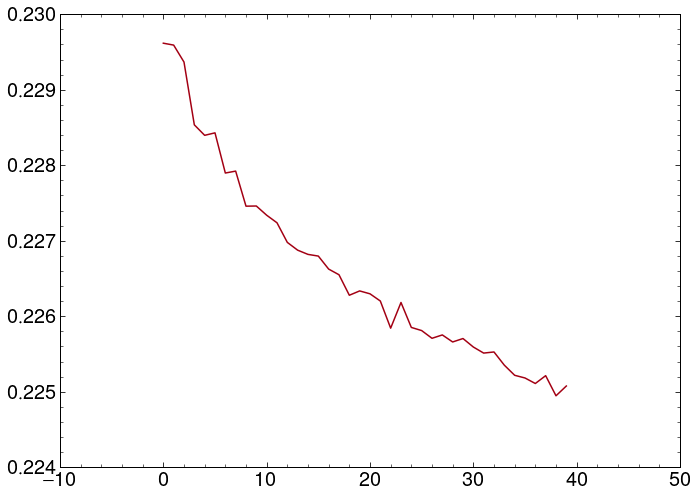

In [26]:
plt.plot(history.history['loss'])